In [1]:
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

import pandas as pd
import tqdm.notebook as tqdm
from multiprocessing import Pool
import seaborn as sns
import subprocess
import os
import pickle
import json 

import py.data_gen as data_gen
import py.algos as algos

plt.rcParams.update({'font.size': 20})

class NumpyEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
  
def save_runs(exp_root, exp_name, runs, args):
    git_hash = algos.get_git_revision_hash()
    dirty = b'script.py' in subprocess.check_output(['git', 'diff', '--name-only'])
    exp_root = os.path.join(exp_root, f'{git_hash}-dirty' if dirty else f'{git_hash}')
    exp_dir = os.path.join(exp_root, exp_name)
    os.makedirs(exp_dir)
    with open(os.path.join(exp_dir, 'results'), 'wb') as f:
        pickle.dump(runs, f)
    with open(os.path.join(exp_dir, 'args' ), 'w') as f:
        json.dump(vars(args), f, indent=True, sort_keys=True, cls=NumpyEncoder)

def get_accepted_per_round(_runs, n_rounds):
  _list1 = []
  for _r in _runs:
    accepted_per_round = np.array(np.array_split(_r, n_rounds)).sum(axis=-1)
    rejected_per_round = 1 - accepted_per_round
    _list1.append(accepted_per_round)
  accepted_per_round = np.concatenate(_list1)
  return accepted_per_round

## harris et. al setup with selection

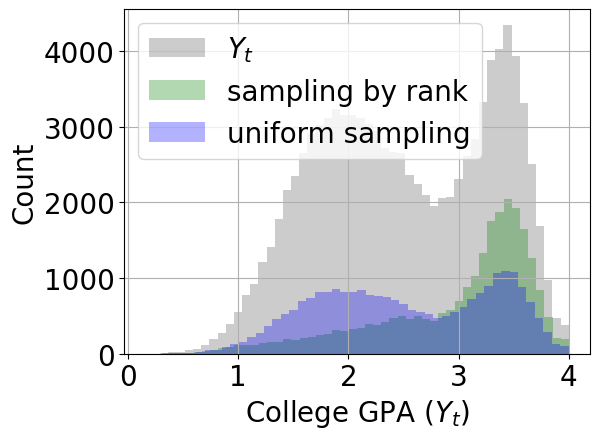

In [7]:
# plot data.
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --clip --envs-accept-rates .25 --rank-type uniform'
args = algos.get_args(cmd)
np.random.seed(1)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = data_gen.generate_data(
    args.num_applicants, args.applicants_per_round, args.fixed_effort_conversion, args
    )

cmd =f'--num-applicants 100000 --applicants-per-round 1000 --clip --envs-accept-rates .25 --rank-type prediction'
args = algos.get_args(cmd)
np.random.seed(1)
b,x,y2,EW,theta, w, z2, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = data_gen.generate_data(
    args.num_applicants, args.applicants_per_round, args.fixed_effort_conversion, args
    )
fig,ax=plt.subplots()
plt.hist(y2[0], alpha=.2 , color='k', bins=50, label=r'$Y_t$')
plt.hist(y2[0][z2==1], color='g', bins=50, alpha=.3, label='sampling by rank')
plt.hist(y[0][z==1], color='b', bins=50, alpha=.3, label='uniform sampling')
ax.grid()
ax.set_xlabel('College GPA ($Y_t$)')
ax.set_ylabel('Count')
ax.legend () 

# assert np.all (y2[0] ==y[0] )
plt.tight_layout()
plt.savefig('figures/haris-et-al-selection-dist.pdf')

In [8]:
n_runs = 50  
# ranking selection
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --clip --methods ols 2sls --envs-accept-rate .25 --rank-type prediction'
args = algos.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(algos.run_multi_env, args_list )
runs = [r[0] for r in runs]

# uniform sampling
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --clip --methods ols 2sls --envs-accept-rate .25 --rank-type uniform'
args = algos.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs2 = p.starmap(algos.run_multi_env, args_list )
runs2 = [r[0] for r in runs2]

99it [00:00, 114.73it/s]
99it [00:00, 106.22it/s]
99it [00:01, 92.21it/s]]
99it [00:00, 111.07it/s]
95it [00:00, 91.93it/s]]
99it [00:00, 101.73it/s]
99it [00:00, 104.94it/s]
93it [00:00, 91.84it/s]]
99it [00:00, 126.92it/s]
99it [00:01, 84.27it/s]]
83it [00:00, 152.91it/s]
95it [00:00, 139.03it/s]
99it [00:01, 91.34it/s]]
99it [00:01, 97.27it/s]]
99it [00:01, 97.42it/s] 
88it [00:00, 88.90it/s]]
89it [00:00, 123.75it/s]
99it [00:00, 148.35it/s]
99it [00:00, 99.67it/s]
99it [00:00, 151.79it/s]
99it [00:01, 89.09it/s]
99it [00:01, 84.18it/s]]
99it [00:01, 76.99it/s]
99it [00:01, 87.96it/s]]
99it [00:00, 143.26it/s]
91it [00:00, 114.08it/s]
88it [00:00, 132.11it/s]
99it [00:00, 144.96it/s]
99it [00:00, 148.14it/s]
99it [00:00, 194.67it/s]
99it [00:01, 88.87it/s]
99it [00:00, 112.49it/s]
99it [00:01, 93.09it/s]]

99it [00:00, 112.86it/s]
99it [00:00, 113.86it/s]
99it [00:00, 183.96it/s]
99it [00:00, 109.13it/s]
99it [00:00, 132.00it/s]

99it [00:00, 136.73it/s]
99it [00:00, 127.56it/s]
99

In [11]:
df = algos.runs2df(runs)
df['sampling'] = 'rank'
df2 = algos.runs2df(runs2)
df2['sampling'] = 'uniform'
df = pd.concat((df, df2 ))

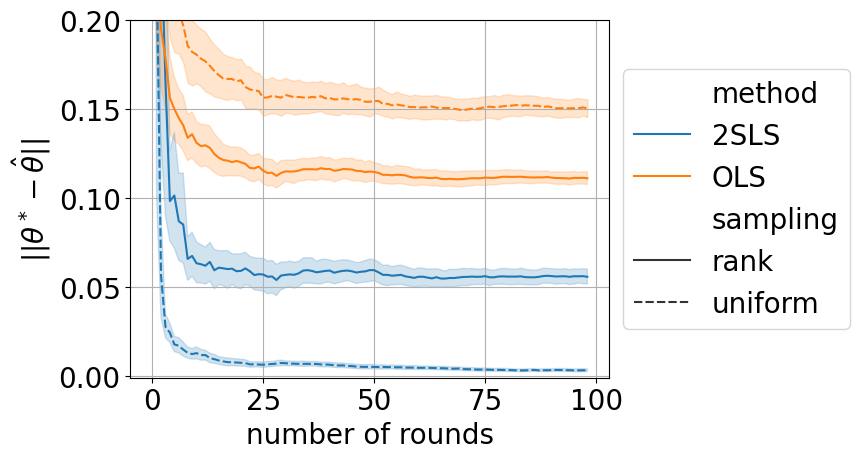

In [12]:
# converting to long format.
# df = script.runs2df(runs)
dflong = pd.melt(df, id_vars=('iterations', 'sampling'), value_vars=('ols_env0', '2sls_env0'), var_name='method', value_name='error')
dflong['method'] = dflong['method'].astype('category')
dflong['method']= dflong['method'].cat.rename_categories({'ols_env0':'OLS', '2sls_env0': '2SLS'})

# plot
fig,ax=plt.subplots(figsize=(9,5))
sns.lineplot(data=dflong, x='iterations', y='error', hue='method', style='sampling', ax=ax)
ax.set_ylim(bottom=-0.001, top=0.2)
ax.legend(loc='upper right')
ax.set_ylabel(r'$||\theta^* - \hat{\theta}|| $')
ax.set_xlabel('number of rounds')
ax.grid()
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('figures/harris-et-al-selection-results.pdf')

In [13]:
save_runs('experiments', 'harris-with-selection', (runs, runs2), args)
# with open('/home/maadil/strategic-iv/experiments/38f2b2def647847bd85caa97013d0f522014871e/harris-with-selection/results', 'rb') as f:
    # runs = pickle.load(f)
# with open('/home/maadil/strategic-iv/experiments/f711f06/harris-with-selection/results', 'rb') as f:
    # runs = pickle.load(f)
# runs 

## our setup.

In [40]:
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours --envs-accept-rate .25'

args = algos.get_args(cmd)
np.random.seed(1)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = data_gen.generate_data(
    args.num_applicants, args.applicants_per_round, args.fixed_effort_conversion, args
    )

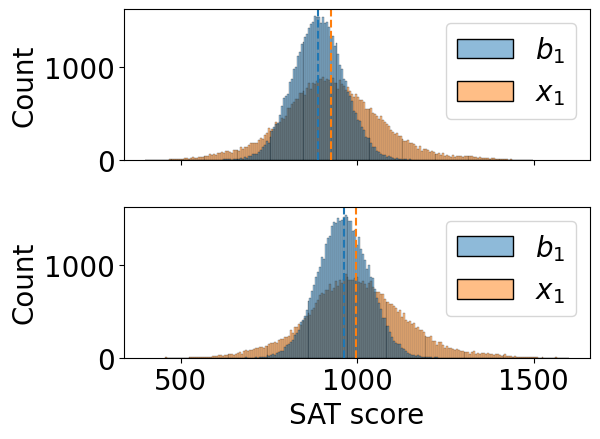

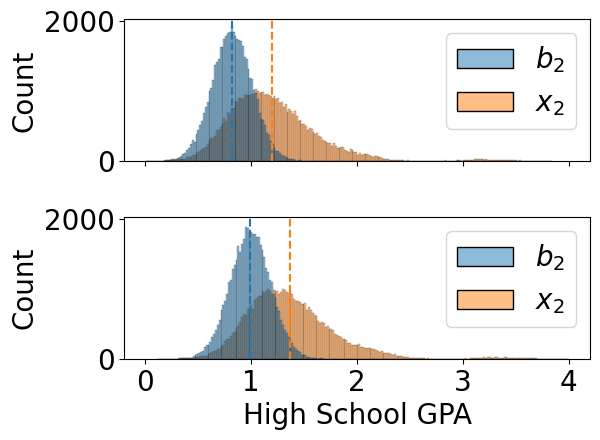

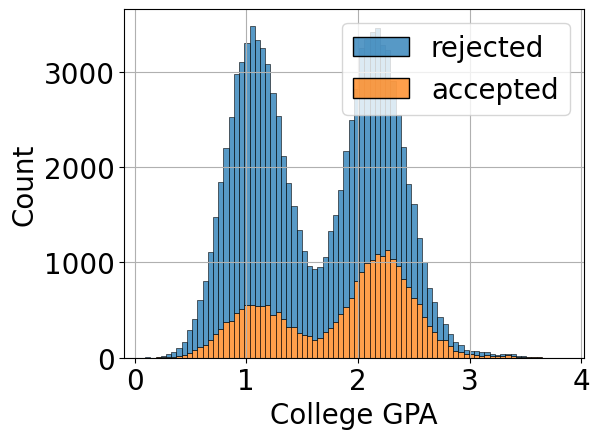

In [41]:
df0 = pd.DataFrame(
    {r'$b_1$': b[disadv_idx,0], r'$b_2$': b[disadv_idx,1], 'status': z[disadv_idx], 'y': y[0, disadv_idx],'y_hat': y_hat[0, disadv_idx],
     r'$x_1$': x[disadv_idx,0], r'$x_2$': x[disadv_idx,1]},
)
df1 = pd.DataFrame(
    {r'$b_1$': b[adv_idx,0], r'$b_2$': b[adv_idx,1], 'status': z[adv_idx], 'y': y[0, adv_idx], r'$x_1$': x[adv_idx, 0], r'$x_2$': x[adv_idx, 1], 'y_hat': y_hat[0, adv_idx]},
)
df0['class'] = 'disadv'
df1['class'] = 'adv'
df = pd.concat((df0, df1))
df['status'] = df.status.astype('category').cat.rename_categories({0.0:'rejected', 1.0: 'accepted'})
df['status']

# SAT score
dflong = pd.melt(df, id_vars=('class'), value_vars=(r'$b_1$', r'$x_1$'), var_name='time', value_name='score')
fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)

g = sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])


g.legend_.set_title(None)
g = sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])
g.legend_.set_title(None)
ax[1].set_xlabel('SAT score')

# four mean lines
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time==r'$b_1$')].score.mean(), color=sns.color_palette()[0], linestyle='--')
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time==r'$x_1$')].score.mean(), color=sns.color_palette()[1], linestyle='--')

ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time==r'$b_1$')].score.mean(), color=sns.color_palette()[0],  linestyle='--')
ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time==r'$x_1$')].score.mean(), color=sns.color_palette()[1],  linestyle='--')

plt.tight_layout()
plt.savefig('figures/our-settings-data1.pdf')

# GPA
dflong = pd.melt(df, id_vars=('class'), value_vars=(r'$b_2$', r'$x_2$'), var_name='time', value_name='score')
fig,ax=plt.subplots(nrows=2, sharex=True, sharey=True)
g = sns.histplot(dflong[dflong['class']=='disadv'], x='score', hue='time', ax=ax[0])
g.legend_.set_title(None)
g = sns.histplot(dflong[dflong['class']=='adv'], x='score', hue='time', ax=ax[1])
g.legend_.set_title(None)
ax[1].set_xlabel('High School GPA')

# four mean lines
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time==r'$b_2$')].score.mean(), color=sns.color_palette()[0], linestyle='--')
ax[0].axvline(x=dflong[(dflong['class']=='disadv') & (dflong.time==r'$x_2$')].score.mean(), color=sns.color_palette()[1], linestyle='--')

ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time==r'$b_2$')].score.mean(), color=sns.color_palette()[0], linestyle='--')
ax[1].axvline(x=dflong[(dflong['class']=='adv') & (dflong.time==r'$x_2$')].score.mean(), color=sns.color_palette()[1], linestyle='--')

plt.tight_layout()
plt.savefig('figures/our-settings-data2.pdf')

# dfa, dfr = pd.DataFrame({'y': y[0][z==1]}), pd.DataFrame({'y': y[0][z==0]})
# df = pd.concat((dfa, dfr))
fig,ax=plt.subplots()
g = sns.histplot(df, x='y', hue='status', ax=ax, multiple='stack')
g.legend_.set_title(None)
ax.set_xlabel('College GPA')
ax.grid()

plt.tight_layout()
plt.savefig('figures/our-settings-data3.pdf')

In [42]:
n_runs =50 
args = algos.get_args(cmd)
args_list = [(s, args) for s in np.arange(n_runs)]
with Pool(n_runs) as p:
    runs = p.starmap(algos.run_multi_env, args_list )
    _runs = [r[2] for r in runs]
runs = [r[0] for r in runs]

92it [00:07,  6.08it/s] 
90it [00:06,  6.33it/s]
99it [00:07, 13.11it/s]
99it [00:07, 12.73it/s]
99it [00:07, 12.48it/s]
99it [00:07, 12.52it/s]
99it [00:07, 12.63it/s]
97it [00:08,  5.83it/s]
96it [00:08,  5.82it/s]
93it [00:08,  5.97it/s]
99it [00:07, 12.95it/s]
99it [00:07, 12.39it/s]
99it [00:08, 11.92it/s]
99it [00:08, 11.82it/s]
96it [00:07,  6.01it/s]
99it [00:07, 12.78it/s]
99it [00:08, 11.90it/s]
99it [00:08, 12.34it/s]
99it [00:07, 12.70it/s]
99it [00:08, 11.81it/s]
99it [00:08, 11.69it/s]
99it [00:07, 12.86it/s]
99it [00:08, 11.90it/s]
99it [00:08, 11.70it/s]

95it [00:08,  6.08it/s]
97it [00:08,  6.07it/s]
99it [00:07, 12.38it/s]
99it [00:08, 11.97it/s]
99it [00:09, 10.96it/s]
99it [00:08, 12.06it/s]
95it [00:07,  6.36it/s]

99it [00:07, 12.99it/s]
99it [00:08, 11.06it/s]
99it [00:09, 10.93it/s]
99it [00:08, 12.21it/s]
99it [00:08, 11.96it/s]
99it [00:08, 12.15it/s]
99it [00:08, 11.15it/s]
99it [00:08, 11.72it/s]
99it [00:09, 10.82it/s]
99it [00:08, 11.09it/s]
99it [00:08, 

In [10]:
# with open('experiments/f711f06/our-settings/results', 'rb') as f:
  # runs = pickle.load(f)
# runs

In [43]:
df = algos.runs2df(runs)
# long format for plotting
value_vars = [f'{m}_env{e}' for m in args.methods for e in range(args.num_envs)]
dflong = pd.melt(df, id_vars='iterations', value_vars=value_vars, var_name='env', value_name='error')
dflong 
dflong['method'] = dflong.env.apply(lambda x: '_'.join(x.split('_')[:-1]))
dflong['env'] = dflong.env.apply(lambda x:x.split('_')[-1])
dflong['method'] = dflong['method'].astype('category')
dflong['method'] = dflong['method'].cat.rename_categories({'ours_vseq': 'Ours', 'ols': 'OLS', '2sls': '2SLS'})
dflong
dflong_stack = dflong # remember for later. 

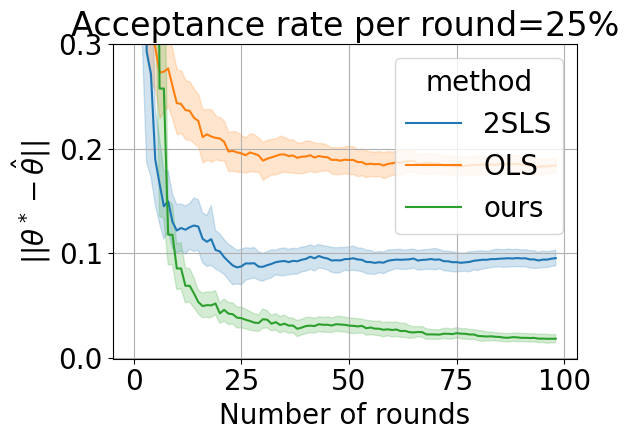

In [44]:
fig,ax=plt.subplots()
sns.lineplot(dflong_stack, x='iterations', y='error', errorbar=('ci', 95), ax=ax, hue='method')
ax.grid()
ax.set_ylim(bottom=-0.001, top=.3)
ax.set_ylabel(r'$|| \theta^* - \hat{\theta}|| $')
ax.set_xlabel('Number of rounds')
ax.set_title('Acceptance rate per round=25%')

plt.tight_layout()
plt.savefig('figures/our-settings-single-env.pdf')

In [45]:
save_runs('experiments', 'our-settings-single-env', runs, args)

In [46]:
## selection function variation. 
n_envs = 1
dfs = []
df_w = []
df_z = []
for env0_accept_rate in (.2, .4, .6, .8, 1.):
    cmd =f'--num-applicants 500000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours --offline-eval --envs-accept-rates {env0_accept_rate}'
    args = algos.get_args(cmd)

    n_runs = 10
    args_list = [(s, args) for s in np.arange(n_runs)]
    with Pool(n_runs) as p:
        runs_data = p.starmap(algos.run_multi_env, args_list )
    
    # recording errors
    runs = [r[0] for r in runs_data]
    df = algos.runs2df(runs)
    df['env0_accept_rate'] = env0_accept_rate
    dfs.append(df)
    
    # recording z
    runs_z = [r[2] for r in runs_data]
    accepted_per_round = get_accepted_per_round(runs_z, args.num_applicants / args.applicants_per_round)
    df = pd.DataFrame({'accepted_per_round': accepted_per_round, 'env0_accept_rate': env0_accept_rate})
    df['rejected_per_round'] = args.applicants_per_round - df['accepted_per_round']
    df_z.append(df)

df = pd.concat(dfs)
# df_w = pd.concat(df_w)
df_z = pd.concat(df_z)
value_vars = [f'{m}_env{ei}' for m in args.methods for ei in range(args.num_envs)]
value_vars
dflong = pd.melt(df, id_vars='env0_accept_rate', value_vars=value_vars, value_name='error', var_name='method_env')
dflong['method'] = dflong.method_env.apply(lambda x: '_'.join(x.split('_')[:-1]))
dflong['env'] = dflong.method_env.apply(lambda x:x.split('_')[-1])  


1it [00:03,  3.28s/it]
1it [00:03,  3.32s/it]
1it [00:03,  3.19s/it]
1it [00:03,  3.19s/it]
1it [00:03,  3.19s/it]
1it [00:03,  3.23s/it]
1it [00:03,  3.28s/it]
1it [00:03,  3.19s/it]
1it [00:03,  3.17s/it]
1it [00:03,  3.17s/it]
1it [00:04,  4.41s/it]
1it [00:04,  4.38s/it]
1it [00:04,  4.37s/it]
1it [00:04,  4.34s/it]
1it [00:04,  4.47s/it]
1it [00:04,  4.32s/it]
1it [00:04,  4.40s/it]
1it [00:04,  4.38s/it]
1it [00:04,  4.39s/it]
1it [00:04,  4.35s/it]
1it [00:05,  5.64s/it]
1it [00:05,  5.54s/it]
1it [00:05,  5.52s/it]
1it [00:05,  5.60s/it]
1it [00:05,  5.53s/it]

1it [00:05,  5.49s/it]
1it [00:05,  5.63s/it]
1it [00:05,  5.53s/it]
1it [00:05,  5.76s/it]
1it [00:06,  6.66s/it]
1it [00:06,  6.81s/it]
1it [00:06,  6.73s/it]
1it [00:06,  6.58s/it]
1it [00:06,  6.82s/it]
1it [00:06,  6.76s/it]
1it [00:07,  7.06s/it]
1it [00:06,  6.73s/it]
1it [00:06,  6.99s/it]
1it [00:06,  6.86s/it]
1it [00:07,  7.93s/it]
1it [00:07,  7.81s/it]
1it [00:07,  7.94s/it]
1it [00:07,  7.99s/it]
1it [00:07

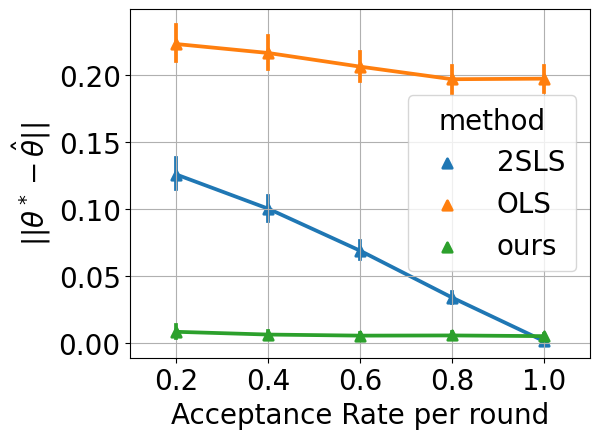

In [48]:
dflong
fig,ax=plt.subplots() 
dflong['method'] = dflong['method'].astype('category')
dflong['method'] = dflong['method'].cat.rename_categories({'2sls': '2SLS', 'ols': 'OLS', 'ours_vseq': 'Ours'})
sns.pointplot(data=dflong[dflong.env=='env0'], x='env0_accept_rate', y='error', hue='method', markers='^')
ax.grid() 

ax.set_xlabel('Acceptance Rate per round')
ax.set_ylabel(r'$|| \theta^* - \hat{\theta}|| $')
plt.tight_layout()
plt.savefig('figures/our-setttings-single-env-ablation.pdf')

In [49]:
save_runs('experiments', 'our-settings-single-env-ablation', dflong, args)

## protocol vs. no protocol (multiple envs.)

In [89]:
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours --num-envs 2 --theta-star-std .1 --envs-accept-rate .5 .5 --num-cooperative-envs 2'
args = algos.get_args(cmd)
np.random.seed(3)
b,x,y,EW,theta, w, z, y_hat, adv_idx, disadv_idx, g, theta_star, pref_vect = data_gen.generate_data(
    args.num_applicants, args.applicants_per_round, args.fixed_effort_conversion, args
    )


1.6502210708204164
1.716850435185807
1.8170594956638126


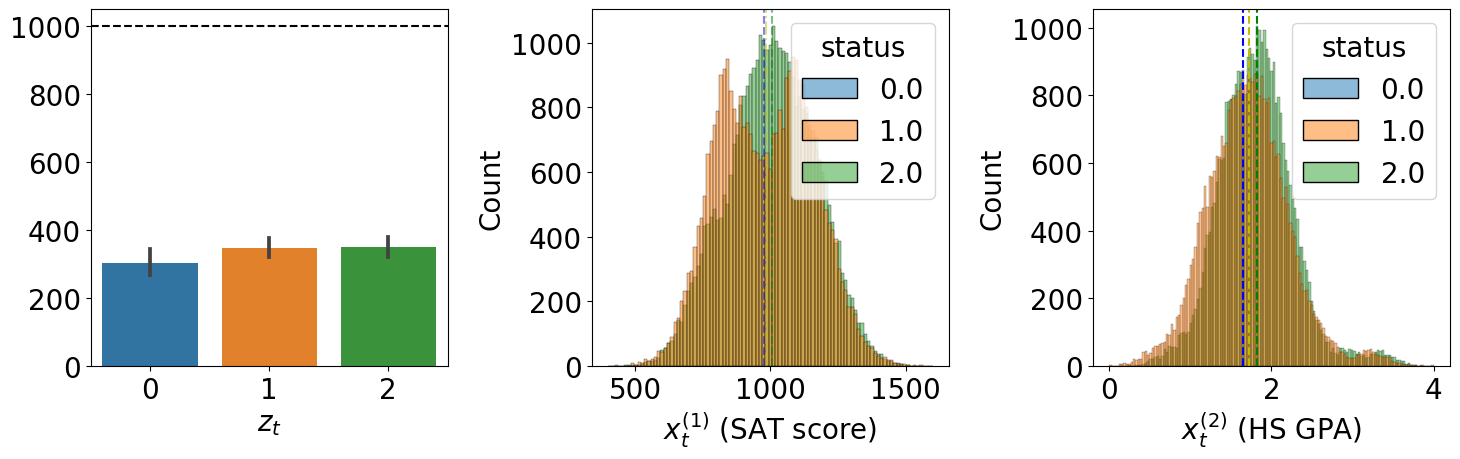

In [90]:

def add_envs(d, idx, var, prefix): 
    d.update({
        f'{prefix}_env{env_idx}': var[env_idx, idx] for env_idx in range(args.num_envs)
    })
    return d

# disadvantage class
df0 = {'b1': b[disadv_idx,0], 'b2': b[disadv_idx,1], 'status': z[disadv_idx], 'y': y[0, disadv_idx],'y_hat': y_hat[0, disadv_idx],
     'x1': x[disadv_idx,0], 'x2': x[disadv_idx,1]}
df0 = add_envs(df0, disadv_idx, y, 'y')
df0 = add_envs(df0, disadv_idx, w, 'w')
df0.keys() 

df0 = pd.DataFrame(df0)
df0['class'] = 'disadv'

# advantaged class
df1 = {'b1': b[adv_idx,0], 'b2': b[adv_idx,1], 'status': z[adv_idx], 'y': y[0, adv_idx],'y_hat': y_hat[0, adv_idx],
     'x1': x[adv_idx,0], 'x2': x[adv_idx,1]}
df1 = add_envs(df1, adv_idx, y, 'y')
df1 = add_envs(df1, adv_idx, w, 'w')
df1.keys() 

df1 = pd.DataFrame(df1)
df1['class'] = 'adv'
df = pd.concat((df0, df1))
df['status'] = df['status'].astype('category')
df
fig,ax=plt.subplots(ncols=3, figsize=(15, 5))

# first plot
df_z = pd.get_dummies(df['status'] ).to_numpy()
df_z = np.array(
  np.split(
    df_z, (args.num_applicants / args.applicants_per_round),  axis=0 
  )
)
ax[0].axhline(y=args.applicants_per_round, color='k', linestyle='--')

assert df_z.shape == ((args.num_applicants / args.applicants_per_round), args.applicants_per_round, args.num_envs+1), f"{df_z.shape}"
df_z = df_z.sum(axis=1) 
sns.barplot(pd.DataFrame(df_z), ax=ax[0])
ax[0].set_xlabel(r'$z_t$')

# second plot
sns.histplot(df[df.status!=0], x='x1', hue='status', ax=ax[1])
ax[1].axvline(x=df[df.status==0].x1.mean(), color='b', alpha=.5, linestyle='--')
ax[1].axvline(x=df[df.status==1].x1.mean(), color='y', alpha=.5, linestyle='-.')
ax[1].axvline(x=df[df.status==2].x1.mean(), color='g', alpha=.5, linestyle='--')
ax[1].axvline(x=df[df.status==3].x1.mean(), color='r', alpha=.5, linestyle='--')
ax[1].set_xlabel(r'$x_t^{(1)}$ (SAT score)')

# third plot
sns.histplot(df[df.status!=0], x='x2', hue='status', ax=ax[2])
for env_idx, c  in zip(range(args.num_envs+1), ('b', 'y', 'g', 'r')):
  print(df[df.status==env_idx].x2.mean())
  ax[2].axvline(x=df[df.status==env_idx].x2.mean(), c=c, linestyle='--')

# ax[2].axvline(x=df[df.status==3].x2.mean(), c='r', linestyle='-.', alpha=.5)
ax[2].set_xlabel(r'$x_t^{(2)}$ (HS GPA)')
plt.tight_layout() 

In [91]:
_runs = []
for nce  in tqdm.tqdm((2, 1)):
    cmd = f'--offline-eval --num-applicants 500000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours --num-envs 2 --theta-star-std .1 --envs-accept-rates .5 --num-cooperative-envs {nce}'
    # print(cmd)
    
    args = algos.get_args(cmd)
    n_runs = 50  
    args_list = [(s, args) for s in np.arange(n_runs)]
    with Pool(n_runs) as p:
        runs = p.starmap(algos.run_multi_env, args_list )
        _runs.append(runs)

  0%|          | 0/2 [00:00<?, ?it/s]

1it [00:04,  4.60s/it]
1it [00:04,  4.52s/it]
1it [00:04,  4.61s/it]
1it [00:04,  4.59s/it]
1it [00:04,  4.59s/it]
1it [00:04,  4.63s/it]
1it [00:04,  4.46s/it]
1it [00:04,  4.40s/it]
1it [00:04,  4.53s/it]
1it [00:04,  4.35s/it]
1it [00:04,  4.61s/it]
1it [00:04,  4.49s/it]
1it [00:04,  4.56s/it]
1it [00:04,  4.50s/it]
1it [00:04,  4.33s/it]
1it [00:04,  4.43s/it]
1it [00:04,  4.34s/it]
1it [00:04,  4.21s/it]
1it [00:04,  4.43s/it]
1it [00:04,  4.50s/it]
1it [00:04,  4.37s/it]
1it [00:04,  4.50s/it]
1it [00:04,  4.30s/it]
1it [00:04,  4.30s/it]
1it [00:04,  4.22s/it]
1it [00:04,  4.18s/it]
1it [00:04,  4.33s/it]
1it [00:04,  4.20s/it]
1it [00:04,  4.27s/it]
1it [00:04,  4.28s/it]
1it [00:04,  4.14s/it]
1it [00:04,  4.12s/it]
1it [00:04,  4.16s/it]
1it [00:04,  4.15s/it]
1it [00:04,  4.08s/it]
1it [00:04,  4.07s/it]
1it [00:04,  4.01s/it]
1it [00:04,  4.05s/it]
1it [00:04,  4.08s/it]
1it [00:03,  3.94s/it]
1it [00:03,  3.97s/it]
1it [00:03,  3.89s/it]
1it [00:03,  3.95s/it]
1it [00:03,

In [95]:
runs0 = [r[0] for r in _runs[0]]
runs1 = [r[0] for r in _runs[1]]
df0 = algos.runs2df(runs0)
df1 = algos.runs2df(runs1)
df0['protocol'] = True
df1['protocol'] = False
df = pd.concat((df0,df1))
df

,iterations,ours_env0,ours_env1,protocol
0,0,0.010066,0.001120,True
1,0,0.001888,0.014179,True
2,0,0.009391,0.007836,True
3,0,0.014977,0.003776,True
4,0,0.007916,0.007949,True
...,...,...,...,...
45,0,0.010949,0.014869,False
46,0,0.005043,0.010077,False
47,0,0.010059,0.007156,False
48,0,0.010886,0.022136,False


In [96]:
dflong = pd.melt(df, id_vars=('iterations', 'protocol'), value_vars=('ours_env0', 'ours_env1'), var_name='env', value_name='error' )
dflong['env']=dflong.env.astype('category').cat.rename_categories({'ours_env0':'1', 'ours_env1': '2'})
dflong 
dflong['cooperative envs.'] = dflong['protocol'].apply(lambda x: 2 if x else 1)
dflong['cooperative envs.'] = dflong['cooperative envs.'].astype('category')
# dflong = dflong.rename(columns={'env': '_env'})
dflong 

,iterations,protocol,env,error,cooperative envs.
0,0,True,1,0.010066,2
1,0,True,1,0.001888,2
2,0,True,1,0.009391,2
3,0,True,1,0.014977,2
4,0,True,1,0.007916,2
...,...,...,...,...,...
195,0,False,2,0.014869,1
196,0,False,2,0.010077,1
197,0,False,2,0.007156,1
198,0,False,2,0.022136,1


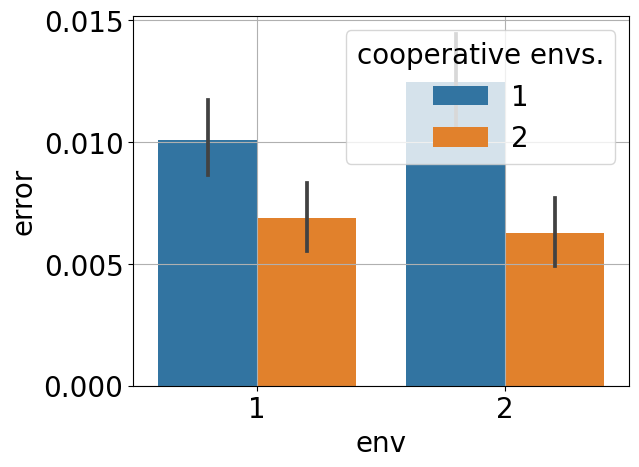

In [97]:
fig,ax=plt.subplots()
sns.barplot(data=dflong, x='env', y='error', hue='cooperative envs.')
ax.grid()

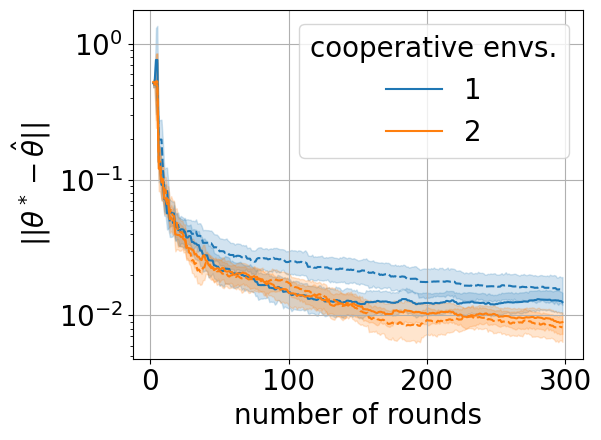

In [52]:
fig,ax=plt.subplots()

sns.lineplot(data=dflong, x='iterations', y='error', style='env',  hue='cooperative envs.', ax=ax)
ax.grid()

# customize the legend
(handles, labels) = ax.get_legend_handles_labels() 
L = ax.legend(handles[1:3], labels[1:3], title='cooperative envs.') 

# x/y labels.
ax.set_xlabel('number of rounds')
ax.set_ylabel(r'$ || \theta^* - \hat{\theta}|| $')
ax.set_yscale('log')
plt.tight_layout() 
plt.savefig('figures/protocol-vs-no-protocol.pdf')

In [53]:
save_runs('experiments', 'protocol-vs-no-protocol', dflong, args)

In [54]:
_runs = []
n_envs = 3
coop_envs = (3, 2)
for nce  in tqdm.tqdm(coop_envs):
    cmd = f'--offline-eval --num-applicants 500000 --applicants-per-round 5000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours --num-envs {n_envs} --theta-star-std .1 --envs-accept-rates .5 --num-cooperative-envs {nce}'
    # print(cmd)
    
    args = algos.get_args(cmd)
    n_runs = 100  
    args_list = [(s, args) for s in np.arange(n_runs)]
    with Pool(n_runs) as p:
        runs = p.starmap(algos.run_multi_env, args_list )
        _runs.append(runs)

  0%|          | 0/2 [00:00<?, ?it/s]

1it [00:01,  1.35s/it]
1it [00:01,  1.33s/it]
1it [00:01,  1.63s/it]
1it [00:01,  1.73s/it]
1it [00:01,  1.41s/it]
1it [00:01,  1.81s/it]
1it [00:01,  1.76s/it]
1it [00:01,  1.60s/it]
1it [00:01,  1.95s/it]
1it [00:02,  2.22s/it]
1it [00:01,  1.05s/it]
1it [00:02,  2.08s/it]
1it [00:02,  2.12s/it]
1it [00:01,  1.87s/it]
1it [00:02,  2.00s/it]
1it [00:01,  1.94s/it]
1it [00:01,  1.68s/it]
1it [00:01,  1.54s/it]
1it [00:01,  1.30s/it]
1it [00:01,  1.29s/it]
1it [00:01,  1.66s/it]
1it [00:01,  1.49s/it]
1it [00:01,  1.58s/it]
1it [00:01,  1.47s/it]
1it [00:01,  1.39s/it]
1it [00:01,  1.89s/it]
1it [00:01,  1.11s/it]
1it [00:01,  1.11s/it]
1it [00:01,  1.36s/it]
1it [00:01,  1.27s/it]
1it [00:01,  1.69s/it]
1it [00:01,  1.47s/it]
1it [00:00,  1.12it/s]
1it [00:01,  1.16s/it]
1it [00:01,  1.26s/it]
1it [00:02,  2.38s/it]
1it [00:01,  1.24s/it]
1it [00:00,  1.01it/s]
1it [00:01,  1.21s/it]
1it [00:01,  1.13s/it]
1it [00:01,  1.13s/it]
1it [00:00,  1.03it/s]
1it [00:01,  1.16s/it]
1it [00:01,

In [58]:
dfs = []
for i, nce in enumerate((coop_envs)):
  df = algos.runs2df([r[0] for r in _runs[i]])
  df['cooperative envs.'] = r'$\{e_1, e_2, e_3\}$' if nce == 3 else r'$\{e_1, e_2\}$'
  dfs.append(df)
# # runs2 = [r[0] for r in _runs[2]]
# df0 = script.runs2df(runs0)
# runs1 = [r[0] for r in _runs[1]]
# df1 = script.runs2df(runs1)
# # df2 = script.runs2df(runs2)
# df0['protocol'] = True
# df1['protocol'] = False
# df = pd.concat((df0,df1))
# df
df = pd.concat(dfs)
df 
df['ours_env0+ours_env1'] = (df['ours_env0'] + df['ours_env1']) / 2.
df 

,iterations,ours_env0,ours_env1,ours_env2,cooperative envs.,ours_env0+ours_env1
0,0,0.003477,0.004488,0.006263,"$\{e_1, e_2, e_3\}$",0.003982
1,0,0.012031,0.006962,0.000964,"$\{e_1, e_2, e_3\}$",0.009497
2,0,0.013893,0.000433,0.001759,"$\{e_1, e_2, e_3\}$",0.007163
3,0,0.004807,0.003717,0.007752,"$\{e_1, e_2, e_3\}$",0.004262
4,0,0.001008,0.014227,0.003051,"$\{e_1, e_2, e_3\}$",0.007618
...,...,...,...,...,...,...
95,0,0.002004,0.002251,0.007066,"$\{e_1, e_2\}$",0.002127
96,0,0.006560,0.010345,0.010648,"$\{e_1, e_2\}$",0.008452
97,0,0.014004,0.013472,0.020794,"$\{e_1, e_2\}$",0.013738
98,0,0.016225,0.016918,0.015263,"$\{e_1, e_2\}$",0.016571


In [59]:
# value_vars= (f'ours_env{i}' for i in range(n_envs))
value_vars=('ours_env0+ours_env1', 'ours_env2')
# rename_categories_arg = {f'ours_env{i}': f'{i+1}' for i in range(n_envs)}
dflong = pd.melt(df, id_vars=('iterations', 'cooperative envs.'), value_vars=value_vars, var_name='env', value_name='error' )
dflong 

dflong['env']=dflong.env.astype('category').cat.rename_categories({'ours_env0+ours_env1': r'avg($e_1, e_2$)', 'ours_env2': r'$e_3$'})
# dflong['cooperative envs.'] = dflong['protocol'].apply(lambda x: 3 if x else 2)
# dflong['cooperative envs.'] = dflong['cooperative envs.'].astype('category')
# dflong = dflong.rename(columns={'env': '_env'})
dflong 

,iterations,cooperative envs.,env,error
0,0,"$\{e_1, e_2, e_3\}$","avg($e_1, e_2$)",0.003982
1,0,"$\{e_1, e_2, e_3\}$","avg($e_1, e_2$)",0.009497
2,0,"$\{e_1, e_2, e_3\}$","avg($e_1, e_2$)",0.007163
3,0,"$\{e_1, e_2, e_3\}$","avg($e_1, e_2$)",0.004262
4,0,"$\{e_1, e_2, e_3\}$","avg($e_1, e_2$)",0.007618
...,...,...,...,...
395,0,"$\{e_1, e_2\}$",$e_3$,0.007066
396,0,"$\{e_1, e_2\}$",$e_3$,0.010648
397,0,"$\{e_1, e_2\}$",$e_3$,0.020794
398,0,"$\{e_1, e_2\}$",$e_3$,0.015263


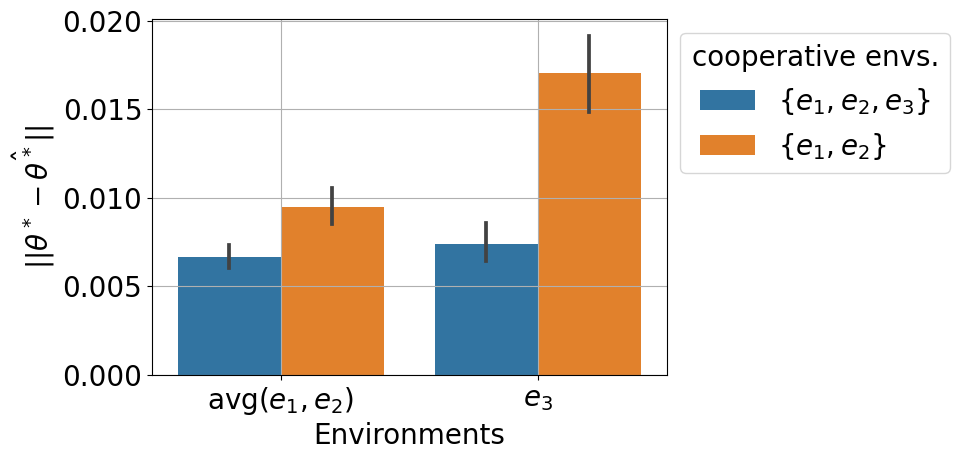

In [60]:
fig,ax=plt.subplots(figsize=(10, 5 ))
sns.barplot(dflong, x='env', hue='cooperative envs.', y='error')
ax.legend(bbox_to_anchor=(1,1), title='cooperative envs.')
ax.grid() 
ax.set_ylabel(r'$|| \theta^* - \hat{\theta^*}||$')
ax.set_xlabel('Environments')

plt.tight_layout()
plt.savefig('figures/experiment-appendix.pdf')

In [61]:
save_runs('experiments', 'protocol-vs-no-protocol-group', dflong, args)

# utility stuff clean

In [2]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import normalize as sk_normalize

from py.agents_gen import AgentsGenericModel
from py.decisions import ThetaGenerator, Simulator

def recover_thetas(args, y, theta, z, env_idx, est_list, test_theta):
    if test_theta == 'theta_star_hat':
        theta_star_est = est_list[f'ours_env{env_idx}'][-1]
        theta_star_est_norm = theta_star_est / np.linalg.norm(theta_star_est)
        return theta_star_est_norm

    elif test_theta == 'theta_ols_hat':
        theta_ols = est_list[f'ols_env{env_idx}'][-1]
        theta_ols /= np.linalg.norm(theta_ols)
        return theta_ols

    elif test_theta == 'theta_ao_hat':
        # recovering theta_ao
        theta_ao_target, theta_ao_input = [] , [] 
        n_rounds = args.num_applicants / args.applicants_per_round

        for t in range(int(n_rounds)):
            lower =t*args.applicants_per_round  
            upper = lower + args.applicants_per_round
  
            idx = z[lower:upper] == env_idx+1
            theta_ao_target.append(y[env_idx, lower:upper][idx].mean())
            theta_ao_input.append(
            theta[env_idx, lower]
        )

        theta_ao_input, theta_ao_target = np.array(theta_ao_input), np.array(theta_ao_target)
        m = LinearRegression()
        m.fit(theta_ao_input, theta_ao_target)
        theta_ao_est = m.coef_ 
        theta_ao_est /= np.linalg.norm(theta_ao_est)
        return theta_ao_est 
    
    else:
        raise NotImplementedError()

def gen_data_train(args, applicants_per_round, fixed_effort_conversion, theta_star, n_rounds, fixed_competitors):
    thegen = ThetaGenerator(length=n_rounds, num_principals=args.num_envs)
    if args.scaled_duplicates is None:
        theta = thegen.generate_randomly()  # (T,n,m)
    elif args.scaled_duplicates == 'sequence':
        theta = thegen.generate_general_coop_case(num_cooperative_principals=args.num_cooperative_envs)
    else:
        raise ValueError(args.scaled_duplicates)

    # TODO (muneeb): refactor this. 
    if fixed_competitors:
        # deployment rule of all but the first principal is fixed.
        for i in range(1, args.num_envs):
            theta[:, i, :] = theta[0, i, :]
    # TODO end (muneeb): refactor this.
    
    sim = Simulator(
        num_agents=applicants_per_round, has_same_effort=fixed_effort_conversion,
        does_clip=args.clip, does_normalise=args.normalize,
        ranking_type=args.rank_type
    )
    sim.deploy(thetas_tr=theta, gammas=args.pref_vect, admission_rates=args.envs_accept_rates)
    u, b_tr, theta, x_tr, eet_mean = sim.u, sim.b_tr, sim.thetas_tr, sim.x_tr, sim.eet_mean

    # true outcomes (college gpa)
    sim.enroll(theta_stars_tr=theta_star)
    o, y = sim.o, sim.y

    # for backwards compatibility
    theta = theta.transpose((1,0,2))
    y = y.T

    assert x_tr[np.newaxis].shape == (1, args.num_applicants, 2)
    assert theta.shape == (args.num_envs, args.num_applicants, 2)
    assert o.shape == (args.num_applicants, args.num_envs)
    assert theta_star.shape == (args.num_envs, 2)

    # our setup addition
    # computing admission results.
    y_hat = sim.y_hat.T
    w, z = sim.w_tr.T, sim.z

    # for backwards compatibility
    adv_idx = np.where(u == True)
    disadv_idx = np.where(u == False)
    adv_idx, disadv_idx = adv_idx[0], disadv_idx[0]

    # ==== function end.
    _,x,y,EET,theta, _, z, _, _, _, _, theta_star, pref_vect = b_tr, x_tr, y, eet_mean, theta, w, z, y_hat, adv_idx, disadv_idx, o.T, theta_star, args.pref_vect
    return theta_star,theta,y,z,x,EET,pref_vect

# generate data. 
def run_multi_env_utility(args, seed, test_theta_envs):
    num_applicants, applicants_per_round, fixed_effort_conversion, args = \
        args.num_applicants, args.applicants_per_round, args.fixed_effort_conversion, args
    theta_star = np.zeros(shape=(args.num_envs, 2))
    theta_star[:, 1] = np.random.normal(loc=0.5, scale=args.theta_star_std, size=(args.num_envs,))

    assert num_applicants % applicants_per_round == 0
    n_rounds = int(num_applicants / applicants_per_round)

    np.random.seed(seed)
    theta_star, theta, y, z, x, EET, pref_vect = gen_data_train(args, applicants_per_round, fixed_effort_conversion, theta_star, n_rounds, True if args.num_envs > 1 else False)

    #  pt. 2: estimating the causal parameters of only the first env.
    err_list, est_list = {}, {}
    env_idx = 0
    dictenv_err, dictenv_est = algos.run_single_env(
        args, x, y, theta, z, theta_star, env_idx, pref_vect, EET, None, None, None
    )
    for k, v in dictenv_err.items():
        err_list[f'{k}_env{env_idx}'] = v
    for k, v in dictenv_est.items():
        est_list[f'{k}_env{env_idx}'] = v
        
    # pt. 3. form test_theta using causal estimate
    test_thetas = np.zeros(shape=(args.num_envs, 2))
    # test_theta for the first env.
    test_thetas[0] = recover_thetas(args, y, theta, z, 0, est_list, test_theta_envs[0])
    # test_theta for the rest. 
    for env_idx in range(1, args.num_envs):
        for k,v in dictenv_err.items():
            err_list[f'{k}_env{env_idx}'] = 0
            est_list[f'{k}_env{env_idx}'] = [theta_star[env_idx]] # using the ground truth theta star for fixed competitors.

        # recovering a test theta for the current environment.
        out = recover_thetas(args, y, theta, z, env_idx, est_list, test_theta_envs[env_idx])
        test_thetas[env_idx ] = out

    test_thetas = test_thetas[np.newaxis]

    # simulate again now using test_thetas 
    # np.random.seed(seed)
    sim_test = Simulator(
        num_agents=applicants_per_round, has_same_effort=fixed_effort_conversion,
        does_clip=args.clip, does_normalise=args.normalize,
        ranking_type=args.rank_type
    )
    sim_test.deploy(thetas_tr=test_thetas, gammas=args.pref_vect, admission_rates=args.envs_accept_rates)
    z_test = sim_test.z
    sim_test.enroll(theta_stars_tr=theta_star)
    o_test, y_test = sim_test.o, sim_test.y

    # compute utilities
    utilities = np.zeros((args.num_envs,))
    for env_idx in range(args.num_envs):
        utilities[env_idx] = y_test[:,  env_idx][z_test==(env_idx+1)].mean()
    return utilities

cmd = '--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours --envs-accept-rate .25 --num-envs 1'
args = algos.get_args(cmd)
seed = 1
test_theta_envs = ('theta_ao_hat', ) * args.num_envs
run_multi_env_utility(args, seed, test_theta_envs)

99it [00:05, 17.41it/s] 


array([2.77056704])

In [29]:
test_thetas.shape

(1, 2, 2)

1it [00:00,  2.36it/s]
1it [00:00,  2.09it/s]
1it [00:00,  1.98it/s]
1it [00:00,  2.22it/s]
1it [00:00,  1.91it/s]
1it [00:00,  2.31it/s]
1it [00:00,  2.50it/s]
1it [00:00,  2.19it/s]
1it [00:00,  2.10it/s]
1it [00:00,  3.42it/s]
1it [00:00,  3.05it/s]
1it [00:00,  2.51it/s]
1it [00:00,  2.07it/s]
1it [00:00,  3.11it/s]
1it [00:00,  1.94it/s]
1it [00:00,  1.58it/s]
1it [00:00,  2.19it/s]
1it [00:00,  1.61it/s]
1it [00:00,  1.56it/s]
1it [00:00,  1.44it/s]
1it [00:00,  1.46it/s]
1it [00:00,  1.16it/s]
1it [00:01,  1.06s/it]
1it [00:01,  1.19s/it]
1it [00:01,  1.23s/it]
1it [00:00,  1.01it/s]
1it [00:01,  1.47s/it]
1it [00:00,  1.02it/s]
1it [00:01,  1.40s/it]
1it [00:01,  1.14s/it]
1it [00:00,  1.45it/s]
1it [00:00,  1.72it/s]
1it [00:00,  2.37it/s]
1it [00:00,  2.38it/s]
1it [00:00,  1.24it/s]
1it [00:00,  1.62it/s]
1it [00:00,  1.62it/s]
1it [00:01,  1.45s/it]
1it [00:00,  2.14it/s]
1it [00:00,  1.94it/s]
1it [00:00,  2.29it/s]
1it [00:00,  1.30it/s]
1it [00:00,  1.26it/s]
1it [00:00,

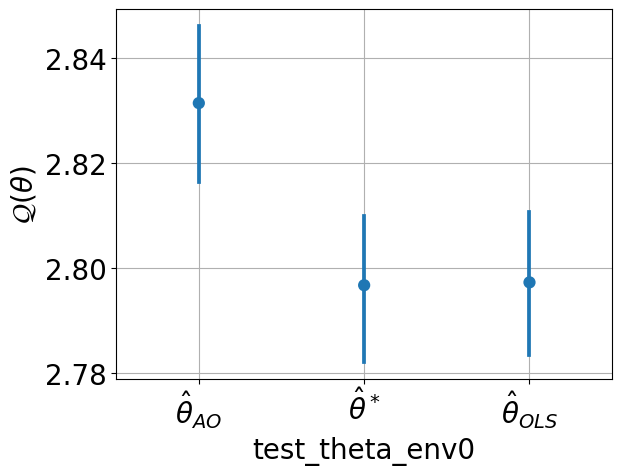

In [9]:
cmd =f'--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods 2sls ols ours --envs-accept-rate .25'
cmd = f'{cmd} --offline-eval'

args = algos.get_args(cmd)
# one environment.
combos = [
    ('theta_ao_hat', ),
    ('theta_star_hat', ),
    ('theta_ols_hat', )
]

dfs = []
for combo in combos:
    n_runs = 100
    args_list = [(args, t, combo) for t in range(n_runs)]
    with Pool(n_runs) as p:
        results = p.starmap(run_multi_env_utility, args_list)

    results = np.array(results)
    pd_dict = {f'perf_env{env_idx}': results[:, env_idx] for env_idx in range(args.num_envs)}
    pd_dict.update(
        {f'test_theta_env{env_idx}': combo[env_idx] for env_idx in range(args.num_envs) }
    )
    df = pd.DataFrame(data=pd_dict)
    dfs.append(df )

df = pd.concat(dfs)
fig,ax=plt.subplots()
sns.pointplot(df, y='perf_env0', x='test_theta_env0', join=False)
ax.set_ylabel(r'$\mathcal{Q}(\theta)$')
ax.set_xticklabels(labels=[r'$\hat{\theta}_{AO}$', r'$\hat{\theta}^*$', r'$\hat{\theta}_{OLS}$'])
ax.grid() 

In [11]:
# cmd = '--num-applicants 100000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours --num-envs 2 --theta-star-std .1 --envs-accept-rates .5 --num-cooperative-envs 2'
cmd = '--num-applicants 500000 --applicants-per-round 1000 --scaled-duplicates sequence --fixed-effort-conversion --normalize --methods ours --num-envs 2 --theta-star-std .1 --envs-accept-rates .5 --num-cooperative-envs 2'
cmd = f'{cmd} --offline-eval'
args =algos.get_args(cmd)

# two envs.
combos = [
    ('theta_ao_hat', 'theta_ao_hat'),
    ('theta_ao_hat', 'theta_star_hat'),
    ('theta_star_hat', 'theta_ao_hat'),
    ('theta_star_hat', 'theta_star_hat')
]

dfs = []
for combo in tqdm.tqdm(combos):
    n_runs = 100
    args_list = [(args, t, combo) for t in range(n_runs)]
    with Pool(n_runs) as p:
        results = p.starmap(run_multi_env_utility, args_list)

    results = np.array(results)
    pd_dict = {f'perf_env{env_idx}': results[:, env_idx] for env_idx in range(args.num_envs)}
    pd_dict.update(
        {f'test_theta_env{env_idx}': combo[env_idx] for env_idx in range(args.num_envs) }
    )
    df = pd.DataFrame(data=pd_dict)
    dfs.append(df )

df = pd.concat(dfs)

  0%|          | 0/4 [00:00<?, ?it/s]

1it [00:05,  5.85s/it]
1it [00:05,  5.76s/it]
1it [00:05,  5.71s/it]
1it [00:05,  5.29s/it]
1it [00:05,  5.69s/it]
1it [00:06,  6.16s/it]
1it [00:05,  5.53s/it]
1it [00:05,  5.56s/it]
1it [00:05,  5.90s/it]
1it [00:05,  5.59s/it]
1it [00:05,  5.58s/it]
1it [00:05,  5.84s/it]
1it [00:05,  5.75s/it]
1it [00:05,  5.62s/it]
1it [00:05,  5.24s/it]
1it [00:05,  5.85s/it]
1it [00:05,  5.65s/it]
1it [00:05,  5.97s/it]
1it [00:05,  5.30s/it]
1it [00:05,  5.52s/it]
1it [00:05,  5.20s/it]
1it [00:05,  5.40s/it]
1it [00:05,  5.50s/it]
1it [00:05,  5.14s/it]
1it [00:05,  5.04s/it]
1it [00:05,  5.41s/it]
1it [00:05,  5.62s/it]
1it [00:05,  5.58s/it]
1it [00:05,  5.44s/it]
1it [00:05,  5.41s/it]
1it [00:05,  5.41s/it]
1it [00:05,  5.11s/it]
1it [00:05,  5.29s/it]
1it [00:05,  5.31s/it]
1it [00:05,  5.46s/it]
1it [00:05,  5.45s/it]
1it [00:05,  5.87s/it]
1it [00:05,  5.16s/it]
1it [00:05,  5.48s/it]
1it [00:05,  5.02s/it]
1it [00:05,  5.27s/it]
1it [00:05,  5.08s/it]
1it [00:05,  5.45s/it]
1it [00:04,

/home/maadil/anaconda3/envs/strategic-iv/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


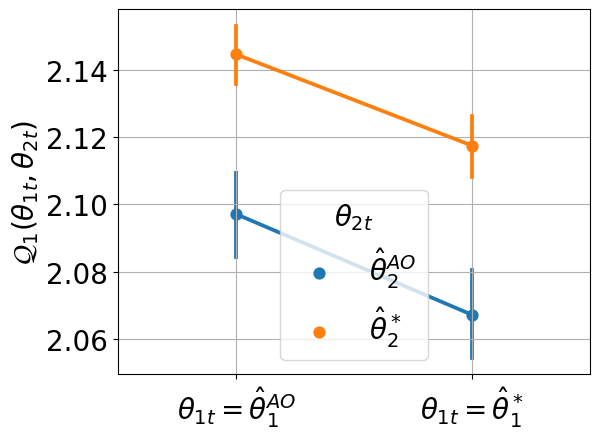

In [12]:
df['test_theta_env0'] = df['test_theta_env0'].astype('category')
df['test_theta_env1'] = df['test_theta_env1'].astype('category')
df
pd.melt(df, id_vars='perf_env0', value_vars=('test_theta_env0', 'test_theta_env1'))
df_ = df[['perf_env0', 'test_theta_env0', 'test_theta_env1']]

df_['test_theta_env1'] = df_['test_theta_env1'].cat.rename_categories({'theta_ao_hat': r'$\hat{\theta}^{AO}_2$', 'theta_star_hat': r'$\hat{\theta}^*_2$'})
df_ = df_.rename(columns={'test_theta_env1': r'$\theta_{2t}$'})
fig,ax=plt.subplots() 
sns.pointplot(df_, y='perf_env0', x='test_theta_env0', hue=r'$\theta_{2t}$', ax=ax)
ax.grid () 

ax.set_ylabel(r'$\mathcal{Q}_1(\theta_{1t}, \theta_{2t})$')
ax.set_xlabel('')
ax.set_xticklabels([r'$\theta_{1t} = \hat{\theta}^{AO}_1$', r'$\theta_{1t} = \hat{\theta}^*_1$'])

plt.tight_layout() 
plt.savefig('figures/utility-multi-env.pdf')